# Example 1: 
* single cell segmentation and classification of cells for rare disease project:

In [1]:
%matplotlib notebook
# %matplotlib inline
%load_ext autoreload
%autoreload 2

# %load_ext tensorboard
# %load_ext tensorboard.notebook
# %tensorboard --logdir {logs_base_dir}

import comet_ml
import sys
sys.path.insert(0, '/home/marziehhaghighi/workspace_DL/Mask_RCNN')
import os
import random
import math
import re
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import copy
# import cell
# config = cell.cellConfig()

import spot
config = spot.spotConfig()
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import warnings
# warnings.filterwarnings('error', category=FutureWarning)

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [1]:
import skimage as sk
sk.__version__

'0.17.2'

In [3]:
# from skimage.draw import disk

#### Project specific parameters

In [2]:
project_name="ISS_spots_clutering"

#### directories
dataset_dir='/storage/data/marziehhaghighi/pooledCP/'
# model_dir = "/storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/"
model_dir = "/storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs/"+project_name+"/"

#### all data information in one dataframe
dfInfo = pd.read_csv(dataset_dir+'workspace/DL_meta/df-Info-pcp-20190919_6W_CP074A-B2-58-3.csv')

### read the raw file for the df Info to form test datset for unannotated images by Marzi
# dfInfo_raw = pd.read_csv(dataset_dir+'PILOT_1_maxproj/scLebelsImgs-'+annotDate+'.csv')
# dfInfo.loc[(dfInfo['Metadata_Location2']=='na') | (dfInfo['Metadata_Location2']=='?'),'subset_label']="test"
dfInfo.loc[(dfInfo['Metadata_Cycle']==6),'subset_label']="test"
# dfInfo['Metadata_Cycle']=

dfInfo["bbox"]=dfInfo["bbox1"]
dfInfo["Location_Center_X"]=dfInfo["Location_Center_X1"]
dfInfo["Location_Center_Y"]=dfInfo["Location_Center_Y1"]

In [57]:
# dfInfo.head()
# np.unique(dfInfo.image_id)
# dfInfo.columns

In [15]:
# dfInfo['bbox']

In [45]:
# dfInfo.Metadata_Label.unique()
# dfInfo.image_id

In [44]:
dfInfo.im_Center_Y.unique()

array([ 256.,  768., 1280., 1792., 2304., 2816., 3328., 3840., 4352.])

In [46]:
# dfInfo.im_Center_Y

In [92]:
# dfInfo.columns
# dfInfo.loc[dfInfo['Metadata_Label']=='not expressed','cat_id'].unique()[0]

#### Run/Experiment specific parameters

In [4]:
# train / test mode
trainMode=0;
testMode=0;

# use of pretrained models --> "imagenet","coco","scratch","last"
init_with = "scratch"

# mask head network to use --> "def" , "unet"
maskBranchNet='def';

# layers to train --> "all" , "heads"
layers_to_tune="all"

# assign_label_mode --> "clustering","classification"
assign_label_mode ="clustering"

# number of randomly selected samples for validation
n_rand_val=20

In [27]:
# model_dir
# testImIds
# dfInfo[dfInfo['subset_label']=='test']
# dfInfo['Metadata_Label']

In [5]:
512/64

8.0

In [40]:
# dfInfo.image_id.unique()

In [5]:
config.project_name=project_name
config.head=maskBranchNet;
fileNumModel=assign_label_mode+'_init_with_'+init_with+'_maskNet_'+maskBranchNet+'_train_'+layers_to_tune;
MODEL_DIR = os.path.join(model_dir+fileNumModel+"/")

# partition dataset to train and validation
# dfInfo=dfInfo[dfInfo['subset_label']!='test'].reset_index(drop=True)
testImIds=dfInfo[dfInfo['subset_label']=='test']['image_id'].unique().tolist()
valImIds=list(np.random.choice(dfInfo[dfInfo['subset_label']!='test']['image_id'].unique().tolist(),n_rand_val))
trainImIds=list(set(dfInfo['image_id'].unique().tolist())-set(valImIds)-set(testImIds))
dfInfo.loc[dfInfo['image_id'].isin(trainImIds),'subset_label']="train"
dfInfo.loc[dfInfo['image_id'].isin(valImIds),'subset_label']="val"

# notexp_cat_id=dfInfo.loc[dfInfo['Metadata_Label']=='not expressed','cat_id'].unique()[0]
# dfInfo.loc[dfInfo['subset_label']=='test','Metadata_Label']='not expressed'
# dfInfo.loc[dfInfo['subset_label']=='test','cat_id']=notexp_cat_id


# prepare train dataset
dataset_train = spot.spotsDataset()
dataset_train.load_spots(dataset_dir,dfInfo,"train")
dataset_train.prepare()


# prepare validation dataset
dataset_val = spot.spotsDataset()
dataset_val.load_spots(dataset_dir,dfInfo,"val")
dataset_val.prepare()


# prepare test dataset
dataset_test = spot.spotsDataset()
dataset_test.load_spots(dataset_dir,dfInfo,"test")
dataset_test.prepare()

if trainMode:
# if 1:
    # create model
    config.assign_label_mode =assign_label_mode#"clustering","classification"
    model = modellib.MaskRCNN(mode="training", config=config,
                              model_dir=MODEL_DIR)   

    if init_with == "imagenet":
        model.load_weights(model.get_imagenet_weights(), by_name=True)
    elif init_with == "coco":
        
        COCO_MODEL_PATH = os.path.join('/storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs/pretrained_coco/',\
                                       "mask_rcnn_coco.h5")
        if not os.path.exists(COCO_MODEL_PATH):
            utils.download_trained_weights(COCO_MODEL_PATH)
        # Load weights trained on MS COCO, but skip layers that
        # are different due to the different number of classes
        # See README for instructions to download the COCO weights
        model.load_weights(COCO_MODEL_PATH, by_name=True,
                           exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                    "mrcnn_bbox", "mrcnn_mask"])
    elif init_with == "last":
        # Load the last model you trained and continue training
        model.load_weights(model.find_last(), by_name=True)
        
        
    model.train(dataset_train, dataset_val, 
                learning_rate=10*config.LEARNING_RATE,
#                 learning_rate=config.LEARNING_RATE / 10,
                epochs=100, 
                layers=layers_to_tune);    

creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!


In [70]:
# dataset_test = cell.cellsDataset()
# dataset_test.load_cells(dataset_dir,dfInfo,"test")
# dataset_test.prepare()
# '/storage/data/marziehhaghighi/pooledCP/20190919_6W_CP074A/images_corrected_cropped/CP074A-B2/CP074A_B2/Cycle04_T/Site_58.tiff'

In [26]:
dataset_val.image_ids

array([0])

<IPython.core.display.Javascript object>


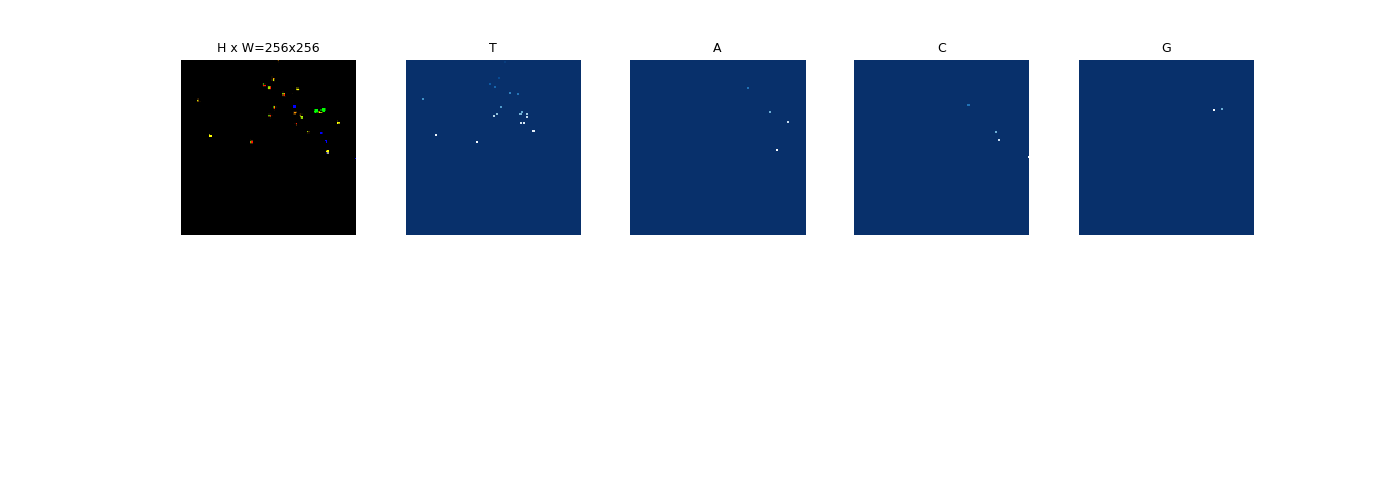

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 1)
# image_ids=[244]
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(visualize.CP_to_RGB_single(image), mask, class_ids, dataset_train.class_names)

In [78]:
# from skimage.draw import disk
# img = np.zeros((10, 10), dtype=np.uint8)
# rr, cc = disk((4, 4), 5)
# img[rr, cc] = 1
# plt.figure()
# plt.imshow(img)

In [25]:
dataset_val.num_classes

5

In [13]:
print(config.RPN_ANCHOR_SCALES,
config.RPN_ANCHOR_RATIOS,
# config.backbone_shapes,
config.BACKBONE_STRIDES,
config.RPN_ANCHOR_STRIDE)

(8, 16, 32, 64, 128, 256) [0.5, 1, 2] [2, 4, 8, 16, 32, 64] 1


In [7]:
# import CellClass
# dfInfo = dfInfo[dfInfo['subset_label']=='test'];
# print(dfInfo.shape) 
# cell = CellClass.CELL(dfInfo)

In [83]:
# cell.dataset['annotations']
# cell.getImgIds(catIds=[11])

In [8]:
# dfInfo.loc[dfInfo['subset_label']=='test',:].head()

In [9]:
# dfInfo.columns

In [ ]:
rsync -rt /cmap/imaging/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/2016_04_01_a549_48hr_batch1 haghighi@dgx01.broadinstitute.org:/dgx1nas1/cellpainting-datasets/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/2016_04_01_a549_48hr_batch1

In [53]:
# dataset_val.class_from_source_map

In [54]:
# # dataset_train.class_from_source_map
# sorted(dataset_train.getCatIds())

In [55]:
# dataset_val.image_info[image_id]

In [58]:
# image_id=2
# dataset_val.source_class_ids[dataset_val.image_info[image_id]["source"]]

In [57]:
# dataset_val.image_info
# dataset_val.source_class_ids

In [56]:
# dataset_train.source_class_ids

In [59]:
# dataset_val.class_info

In [60]:
# dataset_train.class_info

In [6]:
ls /storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_scratch_maskNet_def/

cell20200511T1547/  cell20200512T0040   cell20200512T0144/
cell20200511T2016/  cell20200512T0047   cell20200512T0149/
cell20200511T2238/  cell20200512T0127/  cell20200512T0214/


In [81]:
ls /storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_scratch_maskNet_def/

cell20200511T1547/  cell20200512T0040   cell20200512T0144/  cell20200512T0227/
cell20200511T2016/  cell20200512T0047   cell20200512T0149/  cell20200512T0336/
cell20200511T2238/  cell20200512T0127/  cell20200512T0214/  cell20200513T0503/


In [9]:
# tensorboard --logdir /storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/ --port=6009

In [10]:
# ls /storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_scratch_maskNet_def/cell20200513T0503/

In [61]:
model.find_last()

'/storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_coco_maskNet_def/cell20200520T2314/mask_rcnn_cell_0050.h5'

In [23]:
# [x[0] for x in os.walk(MODEL_DIR)][1]

In [62]:
# ls /storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_scratch_maskNet_def/cell20200513T0503/

#### Inference

In [7]:
class InferenceConfig(spot.spotConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.head=maskBranchNet;
inference_config.DETECTION_MIN_CONFIDENCE=0.8
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
# selectedEpoch='0337'
# # model_path_2=[x[0] for x in os.walk(address)][1]+'/mask_rcnn_cell_'+selectedEpoch+'.h5';
# model_path_2='/'.join(model_path.split('/')[:-1])+'/mask_rcnn_cell_'+str(selectedEpoch)+'.h5';

model_path_2=model_path
# # Load trained weights
print("Loading weights from ", model_path_2)
model.load_weights(model_path_2, by_name=True)

shared Tensor("pool_squeeze/Squeeze_1:0", shape=(?, 1000, 1024), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 1000, 5), dtype=float32)
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  /storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs/ISS_spots_clutering/clustering_init_with_scratch_maskNet_def_train_all/spot20200709T0259/mask_rcnn_spot_0046.h5
Re-starting from epoch 46


In [11]:
model_path

'/storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs/ISS_spots_clutering/init_with_scratch_maskNet_def_train_heads/spot20200624T0005/mask_rcnn_spot_0146.h5'

In [8]:
model_path

'/storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_coco_maskNet_def_train_all/cell20200522T0027/mask_rcnn_cell_0053.h5'

In [34]:
# dataset_val.class_names

In [15]:
# dataset_train.class_names
visualize.CP_to_RGB_single(image).dtype

dtype('float64')

In [16]:
image.dtype

dtype('uint8')

In [80]:
# plt.figure()
# plt.imshow(image[:,:,2])
dataset.image_ids

array([0, 1, 2])

In [13]:
# %matplotlib inline
# plt.figure()
# plt.imshow(visualize.CP_to_RGB_single(image))

In [ ]:
print(1)

In [14]:
# visualize.CP_to_RGB_single(image).dtype

In [ ]:
dataset=copy.copy(dataset_train)
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
#     print(mask[5,5])
visualize.display_top_masks(visualize.CP_to_RGB_single(image), mask, class_ids, dataset.class_names)
# visualize.display_top_masks(image[:,:,1], mask, class_ids, dataset.class_names)

In [20]:
import skimage
image = skimage.io.imread("/home/marziehhaghighi/workspace_DL/Mask_RCNN/images/12283150_12d37e6389_z.jpg")

In [24]:
image.max()

255

In [18]:
ls /home/marziehhaghighi/workspace_DL/Mask_RCNN/images

LICENSE      assets/  images/              mask_rcnn_coco.h5  samples/
MANIFEST.in  build/   logs/                mrcnn/             setup.cfg
README.md    dist/    mask_rcnn.egg-info/  requirements.txt   setup.py


original_image           shape: (256, 256, 4)         min:    0.00000  max:  139.83871  float64
image_meta               shape: (17,)                 min:    0.00000  max: 1985.00000  int64
gt_class_id              shape: (68,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (68, 4)               min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 68)        min:    0.00000  max:    1.00000  bool


<IPython.core.display.Javascript object>


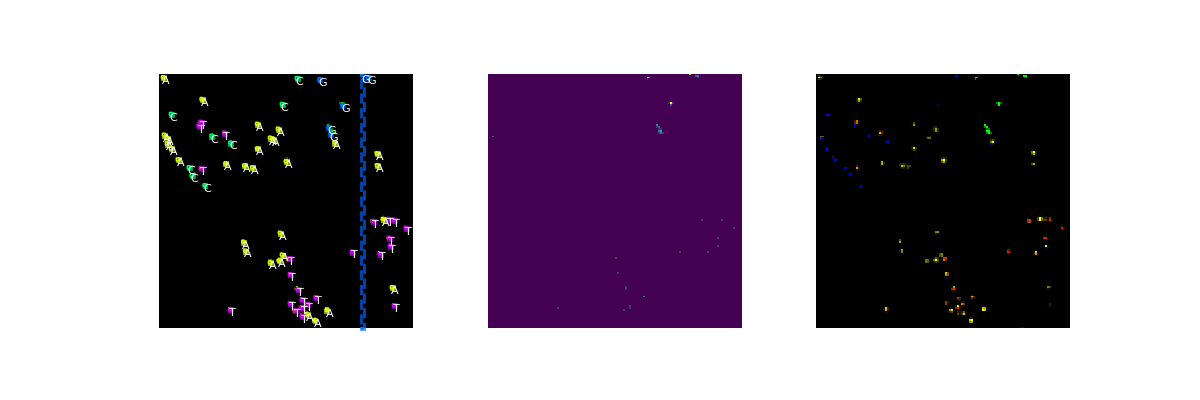

In [18]:
# %matplotlib inline
# Test on a random image from validation set
dataset=copy.copy(dataset_train)

image_id = random.choice(dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(4*3, 4),to_RGB=True, show_mask=False)

In [12]:
# # results
# # original_image.max()
# for i in range(10):
#     image_id = random.choice(dataset.image_ids)
#     or_image2 = dataset.load_image(image_id)
#     print(np.mean(or_image2[:,:,0]),np.mean(or_image2[:,:,1]),np.mean(or_image2[:,:,2]),np.mean(or_image2[:,:,3]))
# # or_image2.shape

In [49]:
# (or_image/or_image.max())*255

In [9]:
original_image.dtype

dtype('uint8')

In [13]:
# results = model.detect([original_image], verbose=1)
# results

Processing 1 images
image                    shape: (256, 256, 4)         min:    0.00000  max:  139.83871  float64
image_meta (17,) [  0 256 256   4 256 256   4   0   0 256 256   1   0   0   0   0   0]
(1, 17)
molded_images            shape: (1, 256, 256, 4)      min:    0.00000  max:  139.83871  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


<IPython.core.display.Javascript object>


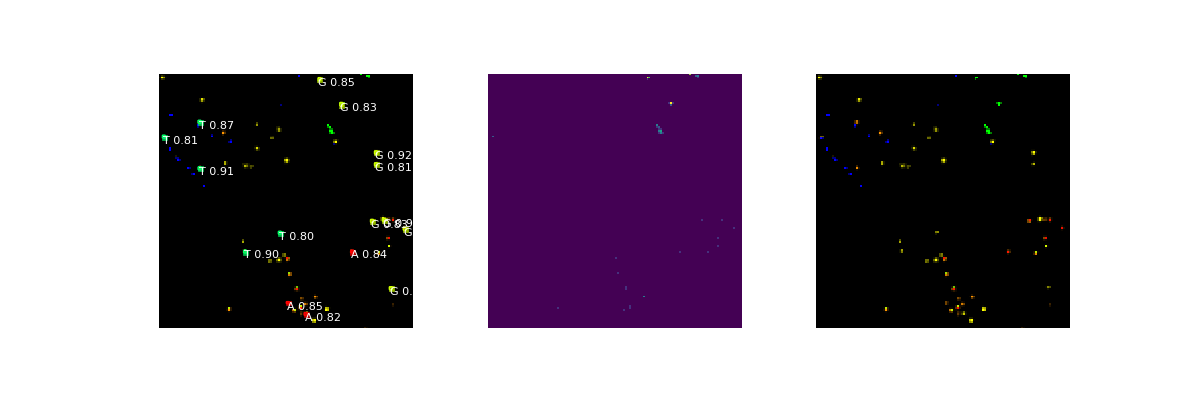

In [19]:
# %matplotlib notebook
# or_image = dataset.load_image(image_id)
# or_image2=(or_image/or_image.max())*255
results = model.detect([original_image], verbose=1)
# results
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'],figsize=(4*3, 4),to_RGB=True)
# visualize.display_instances2(original_image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_train.class_names, r['scores'],figsize=(6*3, 6))

In [14]:
# original_image

In [15]:
# fig,axes=plt.subplots(1,3,figsize=(10,30));
# axes[0].imshow(original_image[:,:,0]);axes[0].set_title('DNA');
# axes[1].imshow(original_image[:,:,1]);axes[1].set_title('Protein');
# # axes[2].imshow(CP_to_RGB_single(original_image));axes[2].set_title('color');
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            4
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   4]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [15]:
original_image.shape

(1024, 1024, 3)

In [16]:
orig_im=skimage.io.imread(imPath)
orig_im2=original_image[:,:,1]

In [17]:
orig_im.shape,orig_im2.shape

((1080, 1080), (1024, 1024))

In [20]:
orig_im.max(),orig_im2.max()

(65535, 255)

In [21]:
orig_im.min(),orig_im2.min()

(182, 0)

In [24]:
orig_im.dtype,orig_im2.dtype

(dtype('uint16'), dtype('uint8'))

In [18]:
orig_im.shape

(1080, 1080)

In [19]:
from scipy import stats
stats.describe(orig_im)

DescribeResult(nobs=1080, minmax=(array([240, 235, 219, ..., 278, 274, 279], dtype=uint16), array([ 3899,  3847,  3732, ..., 48464, 48531, 49751], dtype=uint16)), mean=array([ 491.14722222,  492.95648148,  494.69907407, ..., 5458.48796296,
       5412.7462963 , 5381.75      ]), variance=array([2.59597527e+05, 2.61089172e+05, 2.56731506e+05, ...,
       1.16336875e+08, 1.16221898e+08, 1.16668706e+08]), skewness=array([4.41157648, 4.32222954, 4.27648169, ..., 2.09518809, 2.14170093,
       2.18936505]), kurtosis=array([21.01086081, 19.90798038, 19.35927525, ...,  3.03768322,
        3.30472349,  3.56738775]))

In [69]:
dfInfo[['image_id','bbox','cat_id','P-W-S','ObjectNumber','mask']].head()

,image_id,bbox,cat_id,P-W-S,ObjectNumber,mask
0,56,"[570, 232, 203, 206]",5,RC4_IF_43-G04-2,12,/storage/data/marziehhaghighi/rareDisease/PILO...
1,56,"[189, 730, 196, 207]",18,RC4_IF_43-G04-2,33,/storage/data/marziehhaghighi/rareDisease/PILO...
2,56,"[243, 35, 153, 164]",12,RC4_IF_43-G04-2,2,/storage/data/marziehhaghighi/rareDisease/PILO...
3,56,"[106, 52, 151, 196]",12,RC4_IF_43-G04-2,3,/storage/data/marziehhaghighi/rareDisease/PILO...
4,56,"[479, 47, 149, 225]",12,RC4_IF_43-G04-2,4,/storage/data/marziehhaghighi/rareDisease/PILO...


In [67]:
dfInfo.loc[dfInfo['subset_label']=='test',:][['image_id','bbox','cat_id','P-W-S','ObjectNumber','mask']].head()

,image_id,bbox,cat_id,P-W-S,ObjectNumber,mask
31,8,"[905, 53, 134, 186]",11,RC4_IF_05-G04-3,4,/storage/data/marziehhaghighi/rareDisease/PILO...
32,8,"[147, 55, 106, 155]",11,RC4_IF_05-G04-3,5,/storage/data/marziehhaghighi/rareDisease/PILO...
33,8,"[628, 73, 120, 153]",11,RC4_IF_05-G04-3,6,/storage/data/marziehhaghighi/rareDisease/PILO...
34,8,"[767, 104, 170, 129]",11,RC4_IF_05-G04-3,7,/storage/data/marziehhaghighi/rareDisease/PILO...
35,8,"[470, 84, 160, 146]",11,RC4_IF_05-G04-3,8,/storage/data/marziehhaghighi/rareDisease/PILO...


In [64]:
dataset.image_info[0]

{'id': 8,
 'source': 'cell',
 'path': "['/storage/data/marziehhaghighi/rareDisease/PILOT_1_maxproj/images/RC4_IF_05/r07c04f03p01-ch1sk1fk1fl1.tiff', '/storage/data/marziehhaghighi/rareDisease/PILOT_1_maxproj/images/RC4_IF_05/r07c04f03p01-ch3sk1fk1fl1.tiff', '/storage/data/marziehhaghighi/rareDisease/PILOT_1_maxproj/images/RC4_IF_05/r07c04f03p01-ch2sk1fk1fl1.tiff', '/storage/data/marziehhaghighi/rareDisease/PILOT_1_maxproj/images/RC4_IF_05/r07c04f03p01-ch4sk1fk1fl1.tiff']",
 'width': 1080,
 'height': 1080,
 'annotations': []}

<IPython.core.display.Javascript object>


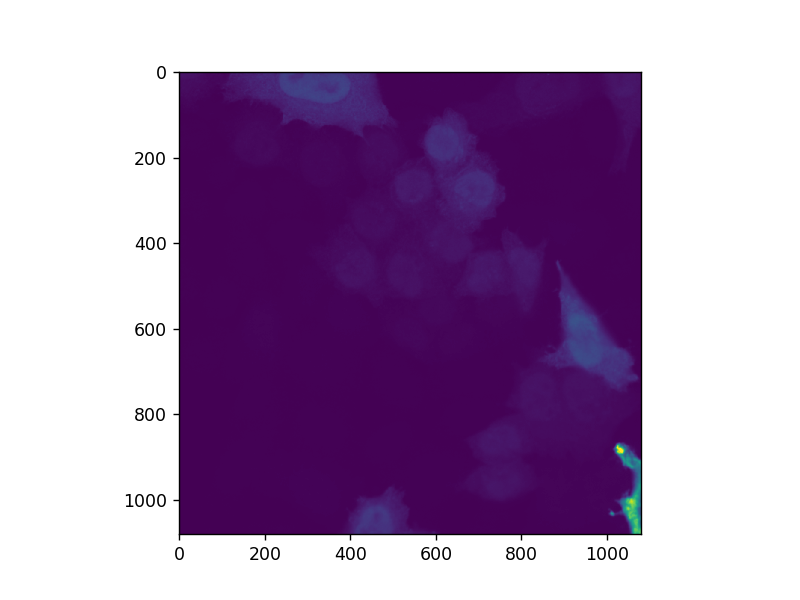

In [35]:
plt.figure()
plt.imshow(dataset.load_image(image_id)[:,:,1]);axes[0].set_title('Protein');

In [85]:
# dataset_test.load_image(image_id)

<IPython.core.display.Javascript object>


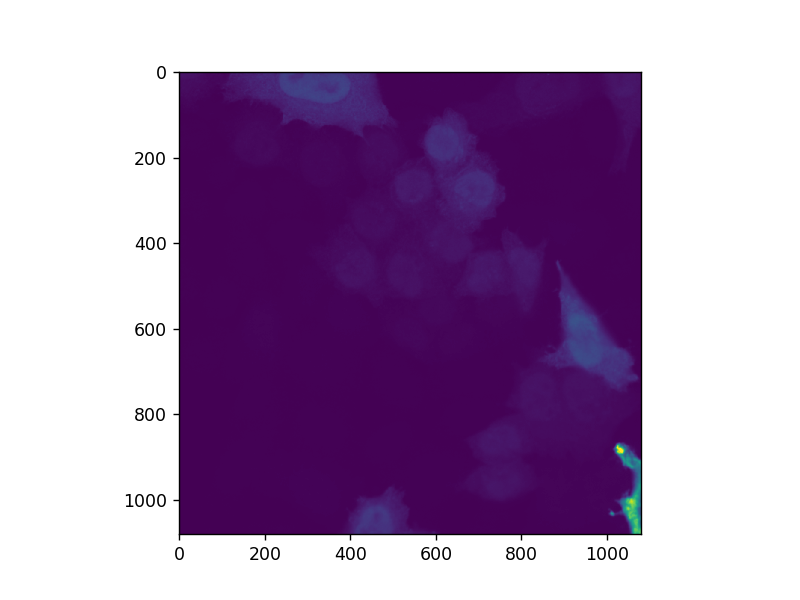

In [32]:
# dataset_test.load_image(image_id)
import skimage.io
from ast import literal_eval
imPath=literal_eval(dataset.image_info[image_id]['path'])[2]

plt.figure()
plt.imshow(skimage.io.imread(imPath))
#         print(len(listOfPaths))
#         listOfPaths=[listOfPaths[0],listOfPaths[2]]
#         listOfPaths=[listOfPaths[2]]
#         imagesList=[]
#         for imPath in listOfPaths:
# #             print(imPath)
#             imagesList.append(skimage.io.imread(imPath).astype('uint8'))


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
image_meta (32,) [   0 1024 1024    3 1024 1024    3    0    0 1024 1024    1    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
(1, 32)
molded_images            shape: (1, 1024, 1024, 3)    min: -128.00000  max:  126.00000  float64
image_metas              shape: (1, 32)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32


<IPython.core.display.Javascript object>


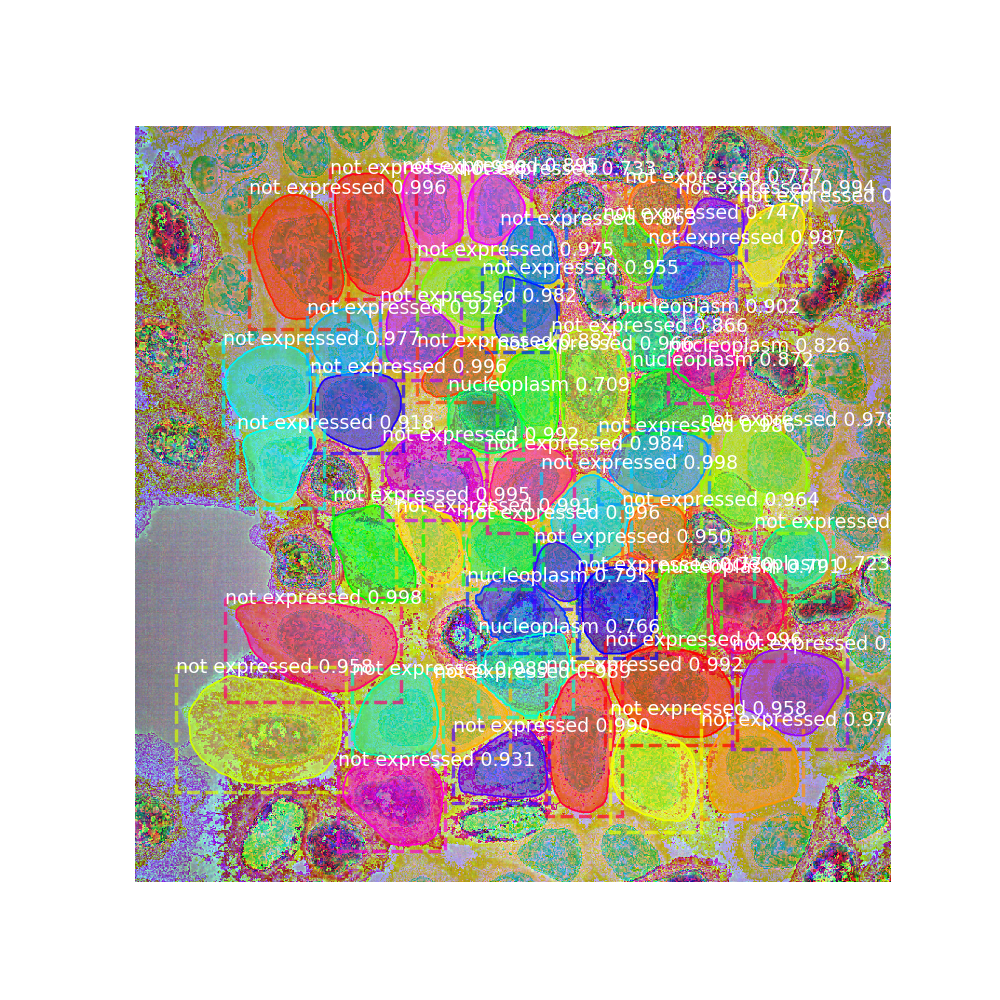

In [51]:
results = model.detect([original_image], verbose=1)
# results
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'],figsize=(8, 8))

In [16]:
original_image

array([[[123, 145, 192],
        [113, 138, 164],
        [118, 134, 170],
        ...,
        [  2, 152,  80],
        [ 13, 192, 172],
        [ 31, 223, 208]],

       [[129, 126, 179],
        [113, 123, 189],
        [114, 124, 205],
        ...,
        [ 25, 180, 112],
        [ 19, 196, 182],
        [ 14, 249,  49]],

       [[126, 120, 185],
        [118, 131, 204],
        [116, 147, 180],
        ...,
        [ 71, 168, 136],
        [ 77, 152,  41],
        [ 44, 210,  78]],

       ...,

       [[108, 124, 195],
        [124, 120, 195],
        [115, 126, 180],
        ...,
        [150, 114,  57],
        [137, 163, 113],
        [142, 228, 202]],

       [[104, 125, 182],
        [121, 121, 183],
        [124, 129, 173],
        ...,
        [140, 147,  66],
        [145, 162, 122],
        [126, 172, 179]],

       [[117, 127, 201],
        [132, 127, 165],
        [130, 130, 192],
        ...,
        [122,  61,  47],
        [143,  45,  78],
        [135, 114, 129]]

In [33]:
original_image.shape

(128, 128, 1)

# Example 2:
    * single cell detection/segmentation and clustering

In [14]:

original_image[:,:,0].shape

(128, 128)

In [72]:
import numpy as np
a=np.random.rand(5,10)
b=np.random.rand(5,10)

In [5]:
a

array([[0.61663802, 0.61383717, 0.87066265, 0.96142386, 0.33702554,
        0.02570697, 0.51764306, 0.67732591, 0.34833994, 0.08976734],
       [0.97313637, 0.82789055, 0.29779494, 0.25196196, 0.79023423,
        0.98380147, 0.65862496, 0.5168325 , 0.12261395, 0.1228047 ],
       [0.92379016, 0.51688631, 0.7518936 , 0.51252832, 0.52000422,
        0.0211729 , 0.58997096, 0.74332169, 0.73286817, 0.86289996],
       [0.73224991, 0.92540816, 0.85502321, 0.74281178, 0.66211381,
        0.65277928, 0.42671495, 0.7061217 , 0.18269861, 0.82430231],
       [0.27834282, 0.1199197 , 0.51363298, 0.1207112 , 0.78528219,
        0.21111073, 0.06885176, 0.34589997, 0.28795184, 0.96193354]])

In [20]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')
distMat=dist.pairwise(a,b)

In [42]:
a[1,:]=np.nan
distMat=dist.pairwise(a,b)

In [45]:
distMat=distMat/np.nansum(distMat,axis=0)

In [46]:
distMat

array([[0.26154628, 0.21074095, 0.22038478, 0.20561807, 0.27869796],
       [       nan,        nan,        nan,        nan,        nan],
       [0.22709331, 0.22153612, 0.24308125, 0.28042593, 0.23947618],
       [0.18155977, 0.26286605, 0.24848488, 0.26448651, 0.27743563],
       [0.32980064, 0.30485688, 0.28804909, 0.24946949, 0.20439023]])

In [48]:
np.nansum(distMat,axis=0)

array([1., 1., 1., 1., 1.])

In [26]:
distMat.sum(axis=0)

array([1., 1., 1., 1., 1.])

In [ ]:
distMat=dist.pairwise(a,b)

In [19]:
a.sum(axis=1)

array([5.05837045, 5.54569564, 6.1753363 , 6.7102237 , 3.69363673])

In [68]:
map_dict={}
min_dist_clusters=np.argmin(distMat,axis=1)
non_nan_indexes=np.delete(range(5), 1)
# non_nan_indexes
for ci in non_nan_indexes:
    map_dict[ci]=min_dist_clusters[ci]

In [69]:
map_dict

{0: 3, 2: 1, 3: 0, 4: 4}

In [52]:
np.argmin(distMat,axis=1)

array([3, 0, 1, 0, 4])

In [65]:
(x==np.nan)

array([False, False, False, False, False])

In [61]:
x=distMat.sum(axis=1)

In [85]:
import numpy as np
a=np.random.rand(5,10)
b=np.random.rand(5,10)

In [106]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')

# nan_index_a=1
nan_index_b=2

# a[nan_index_a,:]=np.nan
b[nan_index_b,:]=np.nan

distMat=dist.pairwise(a,b)
distMat=distMat/np.nansum(distMat,axis=0)
map_dict={}
ordered_ass=np.argsort(distMat,axis=1)
min_dist_clusters=np.nanargmin(distMat,axis=1)
min_dist=np.nanmin(distMat,axis=1)
confid_ordered_labels = np.argsort(min_dist)
# non_nan_indexes=np.delete(range(5), 1)
non_nan_indexes=list(range(5))
for ci in range(5):
#     min_dist_clusters[ci]
    ind_cluster_to_ass=confid_ordered_labels[ci]
    if min_dist_clusters[ind_cluster_to_ass] in non_nan_indexes:
        map_dict[ind_cluster_to_ass]=min_dist_clusters[ind_cluster_to_ass]
        non_nan_indexes.remove(min_dist_clusters[ind_cluster_to_ass])
    else:
        i=1
        while ordered_ass[ind_cluster_to_ass,i] not in non_nan_indexes:
            i += 1
#         for i in range(1,5):
        to_cl=ordered_ass[ind_cluster_to_ass,i]
        map_dict[ind_cluster_to_ass]=to_cl
        non_nan_indexes.remove(to_cl)
    
map_dict
# min_dist_clusters

{4: 3, 3: 1, 2: 4, 0: 0, 1: 2}

In [104]:
min_dist_clusters

array([0, 1, 3, 1, 3])

In [105]:
min_dist

array([0.15761832, 0.21985004, 0.15649114, 0.13887848, 0.12695672])

In [99]:
np.argsort(min_dist)

array([4, 3, 2, 0, 1])

In [95]:
np.sort(distMat,axis=1)

array([[0.15761832, 0.23592548, 0.2729561 , 0.30295652,        nan],
       [0.21985004, 0.22560486, 0.2421656 , 0.26896968,        nan],
       [0.15649114, 0.19101082, 0.19149405, 0.19292334,        nan],
       [0.13887848, 0.16668402, 0.17462637, 0.2368094 ,        nan],
       [0.12695672, 0.14730414, 0.16373085, 0.18704409,        nan]])

In [100]:
ordered_ass=np.argsort(distMat,axis=1)
ordered_ass

array([[0, 4, 3, 1, 2],
       [1, 0, 4, 3, 2],
       [3, 1, 4, 0, 2],
       [1, 4, 3, 0, 2],
       [3, 1, 4, 0, 2]])

In [102]:
ordered_ass[:,1]

array([4, 0, 1, 4, 1])

In [107]:
np.nans((2,3))

AttributeError: module 'numpy' has no attribute 'nans'